In [28]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import seaborn as sb
import cftime

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=-180, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    if var != "snap_siconc":
        test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

def create_date_index(ds, middle_date):
    date_low = (middle_date - 15)%365 + 1
    date_high = (middle_date + 15)%365 + 1
    
    if date_high > date_low: 
            idx = ((ds.time.dt.dayofyear >= date_low) & (ds.time.dt.dayofyear <= date_high))
    if date_high < date_low:
            idx = ((ds.time.dt.dayofyear >= date_low) | (ds.time.dt.dayofyear <= date_high))
            
    return idx

def composites_doy(ds, var): 
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)
    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year
    ds_masked = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )

    flux_avg_tot = flux.mean(dim="snapshot")
    flux_avg_doy = ds_masked.flux.groupby(time.dt.dayofyear).mean(skipna=True)
    
    return ds_masked

In [3]:
models = ["CM4", "ESM4"]

fpath_hfds = {"CM4": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_hfds",
        "ESM4": "/work/Katherine.Turner/tempest-extremes/ESM4/hfds"}

fpath_dic = {"CM4": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_f_dic",
        "ESM4": "/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas"}

In [49]:
m = 'CM4'
ds_hfds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
ds_dic = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
ds_ice = xr.open_dataset('/work/Katherine.Turner/tempest-extremes/odiv-251/comp_ice/comp_siconc.nc', use_cftime=True)
    
hfds_masked = mask_composite(ds_hfds, "snap_hfds_anom")
dic_masked = mask_composite(ds_dic, "snap_dic_stf_gas_anom")
ice_masked = mask_composite(ds_ice, "snap_siconc")

mask = xr.where(np.isnan(hfds_masked), np.nan, 1)

ice_masked = ds_ice.snap_siconc * mask

In [89]:
ice_idx = ice_masked.mean(dim={'x','y'})
hi_ice = ice_idx > np.nanquantile(ice_idx,.9)

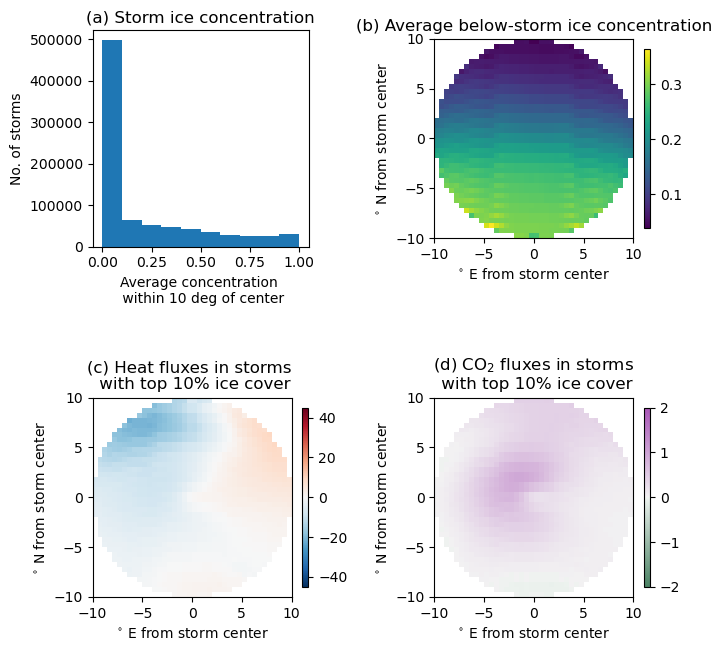

In [97]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
axs=axs.flatten()

xr.plot.hist(ice_masked.mean(dim={'x','y'}), bins = np.arange(0,1.1,.1), density=False, ax=axs[0])

ice_masked.mean("snapshot").plot(ax=axs[1],
                                cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    })

hfds_masked[:,:,hi_ice].mean(dim="snapshot").plot(ax=axs[2], y='y',
                                                  vmin=-45, vmax=45,
                                                  cmap = "RdBu_r",
                                                  cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    })
(-1e3* 60**2 * 24 *dic_masked[:,:,hi_ice]).mean(dim="snapshot").plot(ax=axs[3], y='y',
                                                                     vmin=-2, vmax=2,
                                                      cmap=sb.diverging_palette(145, 300, s=60, as_cmap=True),
                                                 cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    })

axs[0].set_ylabel("No. of storms")
axs[0].set_xlabel("Average concentration \n within 10 deg of center")
axs[0].set_title('(a) Storm ice concentration')

axs[1].set_xlabel('$^{\circ}$ E from storm center')
axs[1].set_ylabel('$^{\circ}$ N from storm center')
axs[1].set_title('(b) Average below-storm ice concentration')

axs[2].set_xlabel('$^{\circ}$ E from storm center')
axs[2].set_ylabel('$^{\circ}$ N from storm center')
axs[2].set_title('(c) Heat fluxes in storms \n with top 10% ice cover')

axs[3].set_xlabel('$^{\circ}$ E from storm center')
axs[3].set_ylabel('$^{\circ}$ N from storm center')
axs[3].set_title('(d) CO$_2$ fluxes in storms \n with top 10% ice cover')

for i in range(4):
    axs[i].set_box_aspect(1)
plt.tight_layout()
plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/CM4_seaice_comps.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/CM4_seaice_comps.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/CM4_seaice_comps.eps",
           format="eps")